# Linear Regression with Mini-Batch Gradient Descent

This notebook demonstrates how to perform linear regression using mini-batch gradient descent on synthetic data. We'll walk through each part of the code step-by-step to understand the concepts involved.

#### **Import Required Libraries**

- **NumPy** is used for numerical operations and handling arrays.
- **Matplotlib** is for plotting graphs to visualize results.
- **TQDM** provides a progress bar for loops.
- **Scikit-learn** is used for calculating the R² score, which evaluates our model.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

pbar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

## 1. Helper Function for all Mini-Batch GD

### Generate Synthetic Data

We create a function to generate synthetic data that follows a linear relationship.
- **Parameters**:
  - `n`: Number of data points.
  - `bias`: Intercept of the line.
  - `weight`: Slope of the line.
- **Output**: An array containing features and labels.

In [2]:
def synthetic_data(n=100, bias=5, weight=2):
    np.random.seed(42)
    torch.manual_seed(42) 

    # Generate synthetic data (linear relationship with some noise)
    bias = 5
    weight = 2
    noise = np.random.randn(n)

    features = np.random.rand(n, 1) * 10
    labels = bias + weight * features.flatten() + noise  # Linear relation with noise

    data = np.hstack((features, labels.reshape(-1, 1)))
    return data

### Visualizing Results

This function will create plots for:
- Loss over epochs
- Values of model parameters (weights)


In [3]:
def plot_results(history, cost_history, lr, fontsize=10, markersize=8):

    history = np.array(history)

    # Create subplots: 3 rows, 1 column
    fig, axs = plt.subplots(history.shape[1] + 1, 1, figsize=(12, 15))  # Adjusted number of rows

    # Plot the loss over epochs
    axs[0].plot(range(len(cost_history)), cost_history, '*-b', markersize=markersize, label='Loss per Epoch')
    axs[0].set_title(f'Loss per Epoch for lr={lr}', fontsize=16, fontweight='bold')
    axs[0].set_xlabel('Iteration', fontsize=fontsize)
    axs[0].set_ylabel('Loss', fontsize=fontsize)
    axs[0].legend()
    axs[0].grid(True)

    # Plot the values of each theta over iterations
    for i in range(history.shape[1]):
        axs[i + 1].plot(history[:, i], '-m.', markersize=markersize, label=f'Theta {i}')
        axs[i + 1].set_title(f'Theta {i} Values over Iterations for lr={lr}', fontsize=fontsize + 4, fontweight='bold')
        axs[i + 1].set_ylabel(f'Theta {i} Value', fontsize=fontsize)
        axs[i + 1].set_xlabel('Iteration', fontsize=fontsize)
        axs[i + 1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


### Evaluate the Model

We define a function to evaluate the model's performance using the R² score:


In [4]:
from sklearn.metrics import r2_score

def evaluate_model(X, y, theta):
    predictions = X @ theta
    return r2_score(y, predictions)

### (optional) Use Decorators to Display Pretty Report after Training

In [5]:
def report_decorator(func):
    def report(*args, **kwargs):

        result = func(*args, **kwargs) 
        epoch, weights_history, cost_history, r2 = result
        
        print("="*60)
        print(" "*20, "Final Training Report")
        print("="*60)
        print(f"🟢 Total Epochs Run : {epoch+1}")
        print(f"🟢 Final MSE        : {cost_history[-1]:.3f}")
        print(f"🟢 Final R-square   : {r2:.3f}")
        print(f"🟢 Final Weights    : [{' '.join(f'{float(w):.4f}' for w in weights_history[-1].flatten())}]")
        print("="*60)
        
        return result
    
    return report

### (optional) Use Decorators to Calculate Time Duration of the Training

In [6]:
import time

def time_decorator(func):
    def training(*args, **kwargs):
        start_time = time.time()        # Start time
        result = func(*args, **kwargs)  # Call the function
        end_time = time.time()          # End time
        print(f"Time taken for {func.__name__}: {end_time - start_time:.4f} seconds")
        return result
    return training

## 2. Mini-Batch Gradient Descent Using Python

The `Mini_BGD_python` function implements the Mini-Batch Gradient Descent (Mini-Batch GD) algorithm using **Python** to optimize the parameters (weights) of a linear regression model.

**Key Changes from SGD to Mini-BGD:**
- **Batch Size Parameter**: A `batch_size` parameter `is added` to control the size of mini-batches.
- **Batch Processing**: Instead of processing one instance at a time, the code processes `batch_size` instances in each iteration.
- **Loss Calculation**: The loss `is calculated` as the mean squared error over the mini-batch.
- **Gradient Calculation**: The gradient `is averaged` over the mini-batch before updating the weights.

### Implementing Stocastic Gradient Descent Using Python

In [7]:
@report_decorator
@time_decorator
def Mini_BGD_python(X, y, **hyperparams):

    np.random.seed(42)    
    # Extract hyperparameters or set default values
    learning_rate = hyperparams.get('learning_rate', 0.0001)
    epochs = hyperparams.get('epochs', 10_000)
    tolerance = hyperparams.get('tolerance', 0.001)
    batch_size = hyperparams.get('batch_size', 4)
    
    X = np.insert(X, 0, 1, axis=1)      # Add Bais to the data
    y = y.reshape(-1, 1)
    m, n = X.shape                      # Number of instance and features
    
    cost_history = []                   # Store all losses per iteration
    avg_losses = []                     # Store all average losses per epoch
    weights_history = []                # Store all weights per iteration
    patience_count = 0                  # Initialize a counter for early stopping
    best_loss = float('inf')            # Initialize best loss with infinity
    theta = np.zeros((n, 1))            # Initialize theta with zeros
    weights_history.append(theta.copy())

    # Progress bar for visual feedback
    pbar = tqdm(total=epochs * m, colour='green', ncols=150, bar_format=pbar_format)
    
    for epoch in range(epochs):

        total_loss = 0                      # Initialize total loss for the epoch
        n_batches = int(m/batch_size)

        indices = np.random.permutation(m)  # Shuffle dataset before the epoch
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(n_batches):
            # 1. Predict output using current theta (weights)
            x_batch, y_batch = X_shuffled[i:(i + batch_size), :], y_shuffled[i]
            h_x = x_batch @ theta

            # 2. Calculate Error for the instance
            e = h_x - y_batch
            loss = np.sum(e ** 2) / (2*batch_size)    # Mean Squared Error (MSE) as loss
            cost_history.append(loss)
            total_loss += loss  # Accumulate the loss for averaging

            # 3. Calculate gradient and update theta
            gradient = (x_batch.T @ e)/batch_size
            
            # 4. Update weights
            theta = theta - learning_rate * gradient
            weights_history.append(theta.copy())

        # Average loss for the epoch
        avg_loss = total_loss / n_batches
        avg_losses.append(avg_loss)

        # Track the best loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_count = 0  # Reset patience count if we improve
        else:
            patience_count += 1  # Increment patience count if no improvement
            
        # Early stopping for convergence
        if patience_count >= 5:  # Check if the loss has not decreased for 5 consecutive epochs
            print(f"Loss increased for 5 consecutive epochs. Stopping training at epoch {epoch + 1}.")
            break

        # Optional Compute r2 score
        r2 = evaluate_model(X, y, theta)

        # Print progress
        pbar.set_description(f"Epoch [{epoch + 1}/{epochs}] - Avg Loss: {avg_loss:.3f} - R2: {r2:.3f} - Weights: {theta.flatten()}")
        pbar.update(batch_size)

    pbar.close()
    return epoch, weights_history, cost_history, r2


### Run the Model

It's essential to understand how different parameters affect the performance of the model. I encourage you to:

1. **Change the Number of Data Points**:
   - Modify the `n` parameter in the `synthetic_data` function and Observe how the amount of training data influences the model's performance and convergence speed.
   - **Example:** Try using `10, 50, 200, or 500` data points.
   - **Note:** This will help you understand how the model's performance scales with the amount of training data.

2. **Adjust the Learning Rate**:
   - Experiment with different **learning rates** in the `Mini_BGD_python` function and Observe how the **learning rate** affects convergence.
   - **Example:** Common values to try include `0.01, 0.001, and 0.0001`.
   - **Note:** A learning rate that is too high can cause the model to oscillate before convergence, while a learning rate that is too low can slow down convergence.

3. **Adjust the Epochs Numbers**:
   - Experiment with different numbers of **epochs** in the `Mini_BGD_python` function. Observe how the number of **epochs** affects the model's performance and convergence.
   - **Example:** try `100, 500, or 1000` epochs.
   - **Note:** A larger number of epochs may lead to better convergence but may also increase training time.

### Use Small Learning Rate

In [8]:
# Generate 50 synthetic data points
data = synthetic_data(n=50, bias=5, weight=2)
X, y = data[:, :-1], data[:, -1]
print(f"X: {X}\n \n y: {y}")

X: [[1.40924225]
 [8.02196981]
 [0.74550644]
 [9.86886937]
 [7.72244769]
 [1.98715682]
 [0.05522117]
 [8.15461428]
 [7.06857344]
 [7.29007168]
 [7.71270347]
 [0.74044652]
 [3.58465729]
 [1.1586906 ]
 [8.63103426]
 [6.23298127]
 [3.30898025]
 [0.6355835 ]
 [3.10982322]
 [3.25183322]
 [7.29606178]
 [6.37557471]
 [8.87212743]
 [4.72214925]
 [1.19594246]
 [7.13244787]
 [7.60785049]
 [5.61277198]
 [7.7096718 ]
 [4.93795596]
 [5.22732829]
 [4.27541018]
 [0.25419127]
 [1.07891427]
 [0.31429186]
 [6.36410411]
 [3.14355981]
 [5.08570691]
 [9.07566474]
 [2.49292229]
 [4.10382923]
 [7.55551139]
 [2.28798165]
 [0.7697991 ]
 [2.89751453]
 [1.61221287]
 [9.29697652]
 [8.0812038 ]
 [6.33403757]
 [8.7146059 ]]
 
 y: [ 8.31519865 20.90567531  7.13870141 26.26076859 20.21074201  8.74017667
  6.68965516 22.0766633  18.66767249 20.1227034  19.96198924  6.01516328
 12.41127684  5.40410095 20.53715068 16.90367501 10.60512938  6.58541434
 10.31162236 10.09136274 21.05777234 17.52537313 22.81178306 13.0195503

In [9]:
# Initialize hyperparameters
lr = 0.0001

# Run Stocastic GD
_, weights_history, cost_history, r2 = Mini_BGD_python(X, y, learning_rate=lr)

Epoch [5/10000] - Avg Loss: 109.557 - R2: -3.972 - Weights: [0.07969379 0.38750343]:   0%|                       | 20/500000 [00:00<12:10, 684.12it/s]

Loss increased for 5 consecutive epochs. Stopping training at epoch 6.
Time taken for Mini_BGD_python: 0.0342 seconds
                     Final Training Report
🟢 Total Epochs Run : 6
🟢 Final MSE        : 148.378
🟢 Final R-square   : -3.972
🟢 Final Weights    : [0.0951 0.4691]


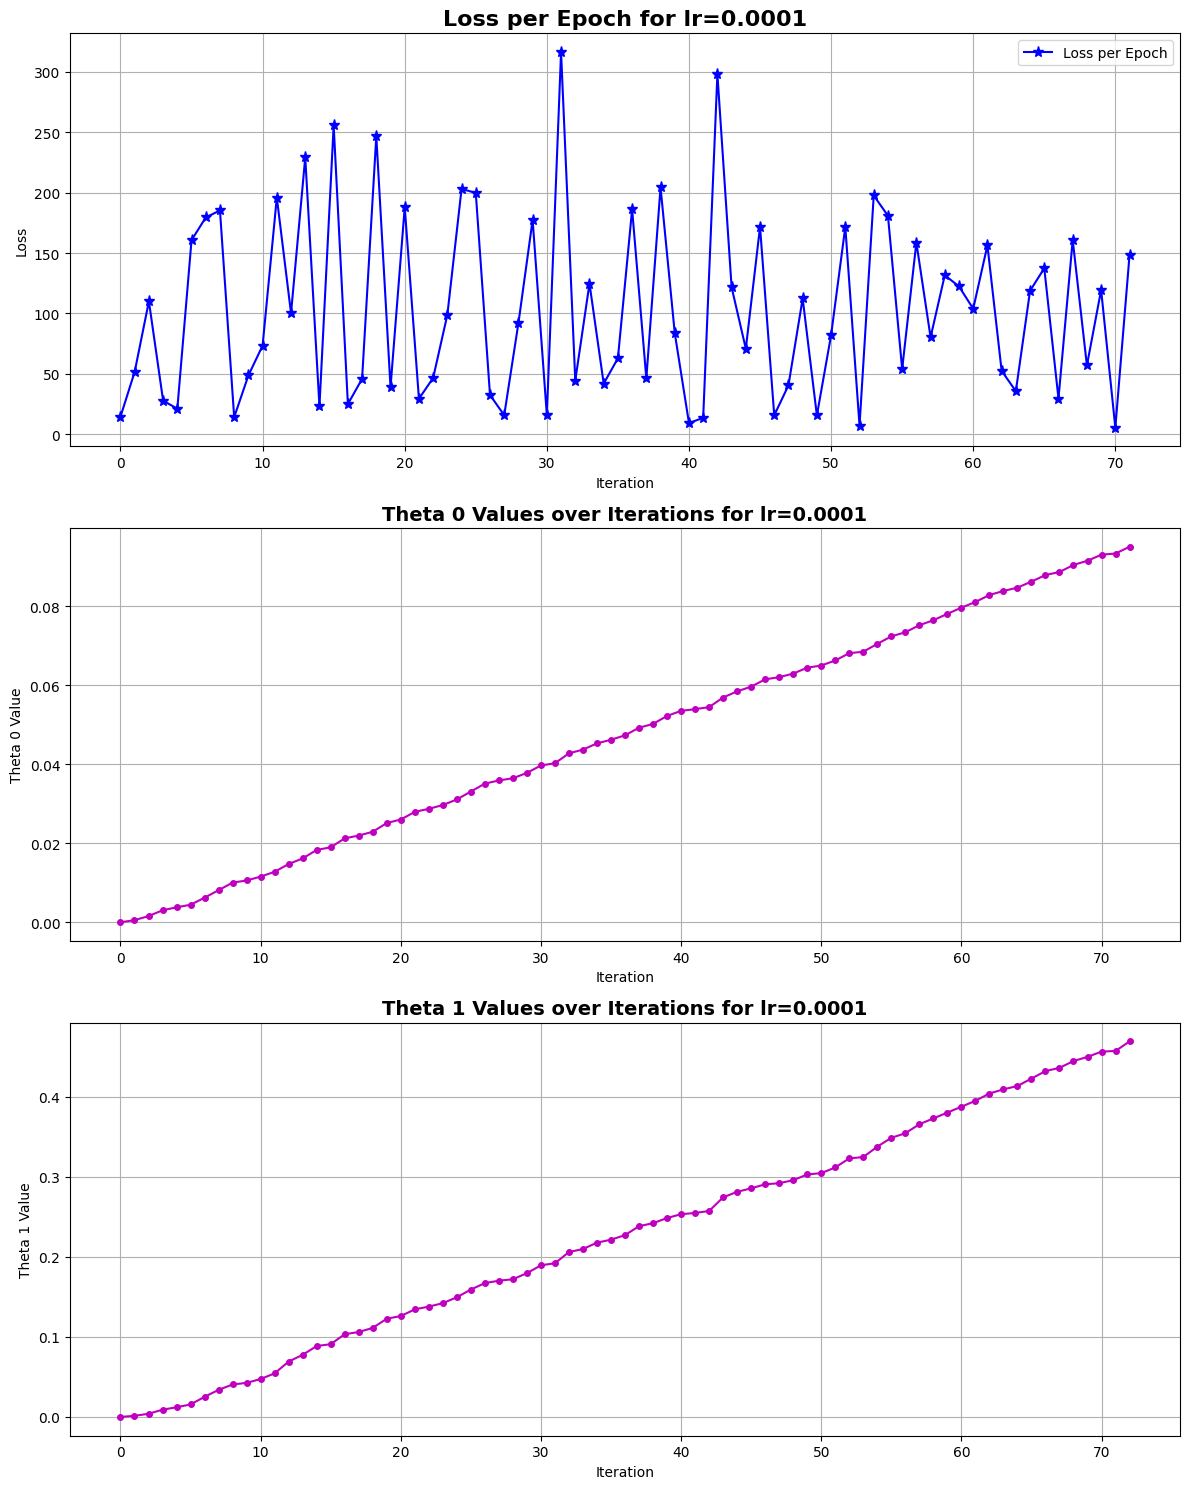

In [10]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)

### Use Large Learning Rate

In [11]:
lr = 0.05

# Run Stocastic GD
_, weights_history, cost_history, r2 = Mini_BGD_python(X, y, learning_rate=lr)

Epoch [5/10000] - Avg Loss: 56.309 - R2: 0.922 - Weights: [6.47772312 1.54823491]:   0%|                        | 20/500000 [00:00<07:59, 1042.11it/s]

Loss increased for 5 consecutive epochs. Stopping training at epoch 6.
Time taken for Mini_BGD_python: 0.0233 seconds
                     Final Training Report
🟢 Total Epochs Run : 6
🟢 Final MSE        : 1021.001
🟢 Final R-square   : 0.922
🟢 Final Weights    : [8.6284 13.3566]


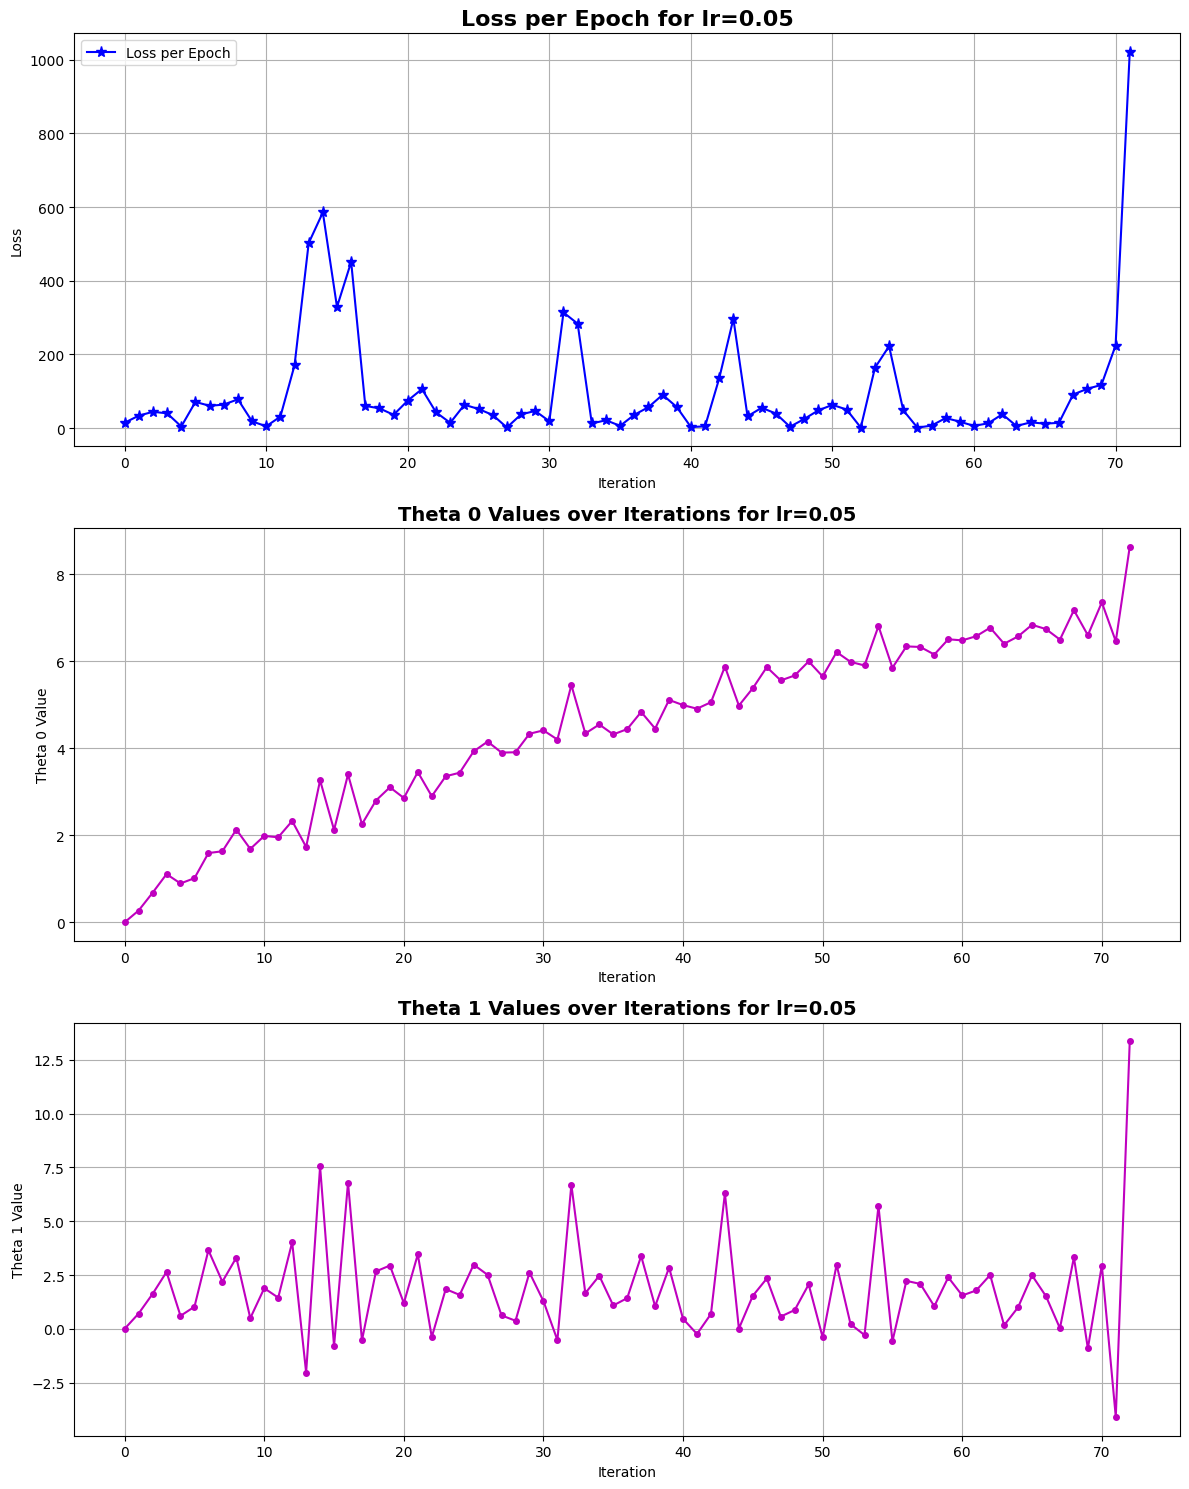

In [12]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)

## 3.Mini-Batch Gradient Descent Using PyTorch
The `Mini_BGD_python` function implements the Stocastic gradient descent algorithm using **PyTorch** to optimize the parameters (weights) of a linear regression model.

**Key Changes from the Python Code:**
1. **Data Conversion**: The input data `X` and `y` are converted to PyTorch tensors.
2. **Bias Term**: The bias term is added using `torch.cat` to create a column of ones.
3. **Gradient Calculation**: The gradient  is calculated using tensor operations, leveraging PyTorch's matrix multiplication.
4. **Loss Calculation**: Losses are appended as Python floats using `loss.item()`.
5. **Weights Update**: The weights are updated in place using standard tensor operations.

### Implementing Mini-BGD Using PyTorch

In [13]:
@report_decorator
@time_decorator
def Mini_BGD_pytorch(X, y, **hyperparams):
    
    np.random.seed(42)
    torch.manual_seed(42) 
    
    # Extract hyperparameters or set default values
    learning_rate = hyperparams.get('learning_rate', 0.0001)
    epochs = hyperparams.get('epochs', 10_000)
    batch_size = hyperparams.get('batch_size', 4)
    tolerance = hyperparams.get('tolerance', 0.001) 
    
    # Number of training examples, number of features
    X = np.insert(X, 0, 1, axis=1)                    # Add bias term (intercept)
    m, n = X.shape

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
      
    cost_history = []                                 # Store all losses per iteration
    avg_losses = []                                   # Store all average losses per epoch
    weights_history = []                              # Store all weights per iteration
    patience_count = 0                                # Initialize a counter for early stopping
    best_loss = float('inf')                          # Initialize best loss with infinity
    theta = torch.zeros((n, 1), dtype=torch.float32)  # Initialize theta with zeros
    weights_history.append(theta.clone())

    # Progress bar for visual feedback
    pbar = tqdm(total=epochs * m, colour='green', ncols=150, bar_format=pbar_format)
    
    for epoch in range(epochs):
        total_loss = 0  # Initialize total loss for the epoch
        n_batches = int(m/batch_size)

        indices = np.random.permutation(m)  # Shuffle dataset before the epoch
        X_shuffled = X_tensor[indices]
        y_shuffled = y_tensor[indices]
        
        for i in range(n_batches):
            # 1. Predict output using current theta (weights)
            x_batch, y_batch = X_shuffled[i:(i+batch_size), :] , y_shuffled[i]
            h_x = x_batch @ theta

            # 2. Calculate Error for the instance
            e = h_x - y_batch
            loss = torch.sum(e.t() @ e)/(2*batch_size)       # torch.mean(e ** 2)
            cost_history.append(loss.item())                 # Append loss as a Python float
            total_loss += loss.item()                        # Accumulate the loss for averaging

            # 3. Calculate gradient and update theta
            gradient = (x_batch.t() @ e) / batch_size
            
            # 4. Update weights using a learning rate
            theta = theta - learning_rate * gradient
            weights_history.append(theta.clone())

        # Average loss for the epoch
        avg_loss = total_loss / n_batches
        avg_losses.append(avg_loss)

        # Track the best loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_count = 0  # Reset patience count if we improve
        else:
            patience_count += 1  # Increment patience count if no improvement
            
        # Early stopping for convergence
        if patience_count >= 5:  # Check if the loss has not decreased for 5 consecutive epochs
            print(f"Loss increased for 5 consecutive epochs. Stopping training at epoch {epoch + 1}.")
            break

        # Optional Compute r2 score
        r2 = evaluate_model(X, y, theta.detach().numpy())

        # Print progress
        pbar.set_description(f"Epoch [{epoch + 1}/{epochs}] - Avg Loss: {avg_loss:.3f} - R2: {r2:.3f} - Weights: {theta.flatten().tolist()}")
        pbar.update(m)

    pbar.close()
    return epoch, weights_history, cost_history, r2

### Use Small Learning Rate

In [14]:
# Initialize hyperparameters
lr = 0.0001

# Run Stocastic GD
_, weights_history, cost_history, r2 = Mini_BGD_pytorch(X, y, learning_rate=lr)

Epoch [5/10000] - Avg Loss: 109.557 - R2: -3.972 - Weights: [0.07969377934932709, 0.38750341534614563]:   0%|  | 250/500000 [00:00<01:21, 6164.72it/s]

Loss increased for 5 consecutive epochs. Stopping training at epoch 6.
Time taken for Mini_BGD_pytorch: 0.0527 seconds
                     Final Training Report
🟢 Total Epochs Run : 6
🟢 Final MSE        : 148.378
🟢 Final R-square   : -3.972
🟢 Final Weights    : [0.0951 0.4691]


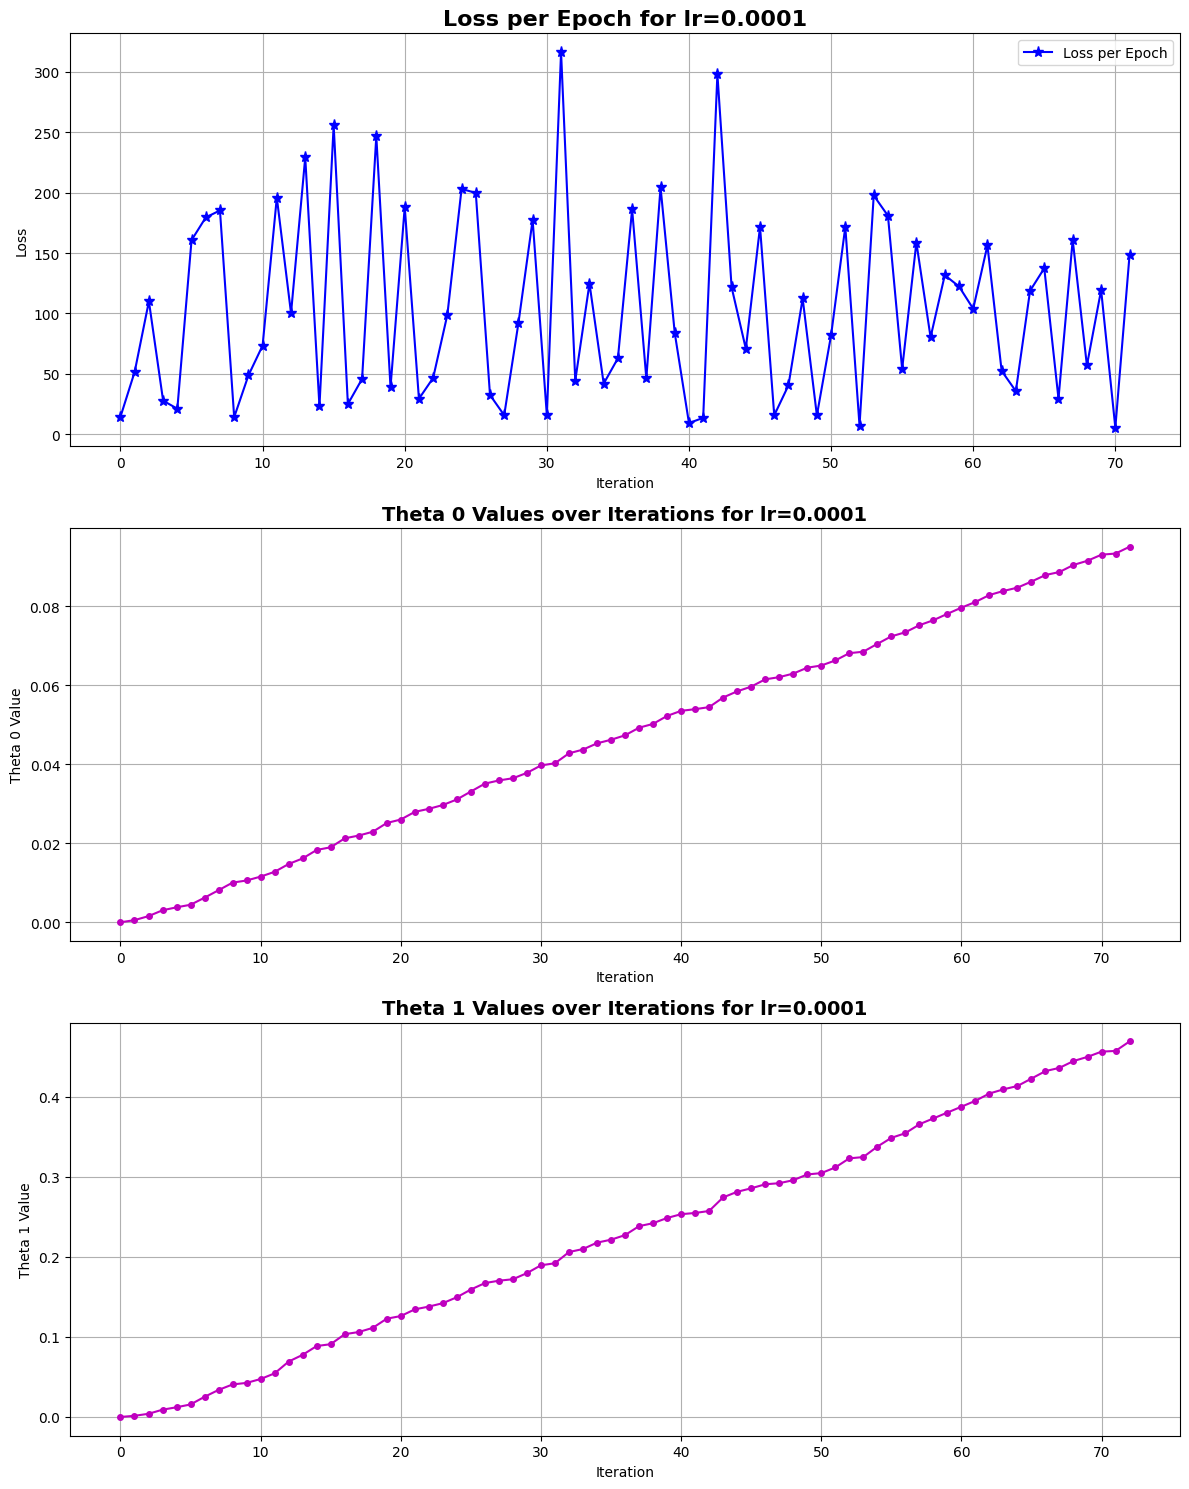

In [15]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)

### Use Large Learning Rate

In [16]:
lr = 0.1

# Run Stocastic GD
_, weights_history, cost_history, r2 = Mini_BGD_pytorch(X, y, learning_rate=lr)

Epoch [5/10000] - Avg Loss: 184338279333901231131352639716982784.000 - R2: -395059003024952935011111231503204352.000 - Weights: [-1.0602527061127987e+0/500000 

Loss increased for 5 consecutive epochs. Stopping training at epoch 6.
Time taken for Mini_BGD_pytorch: 0.0574 seconds
                     Final Training Report
🟢 Total Epochs Run : 6
🟢 Final MSE        : inf
🟢 Final R-square   : -395059003024952935011111231503204352.000
🟢 Final Weights    : [-5997481904366122172416.0000 -50278906815904596623360.0000]


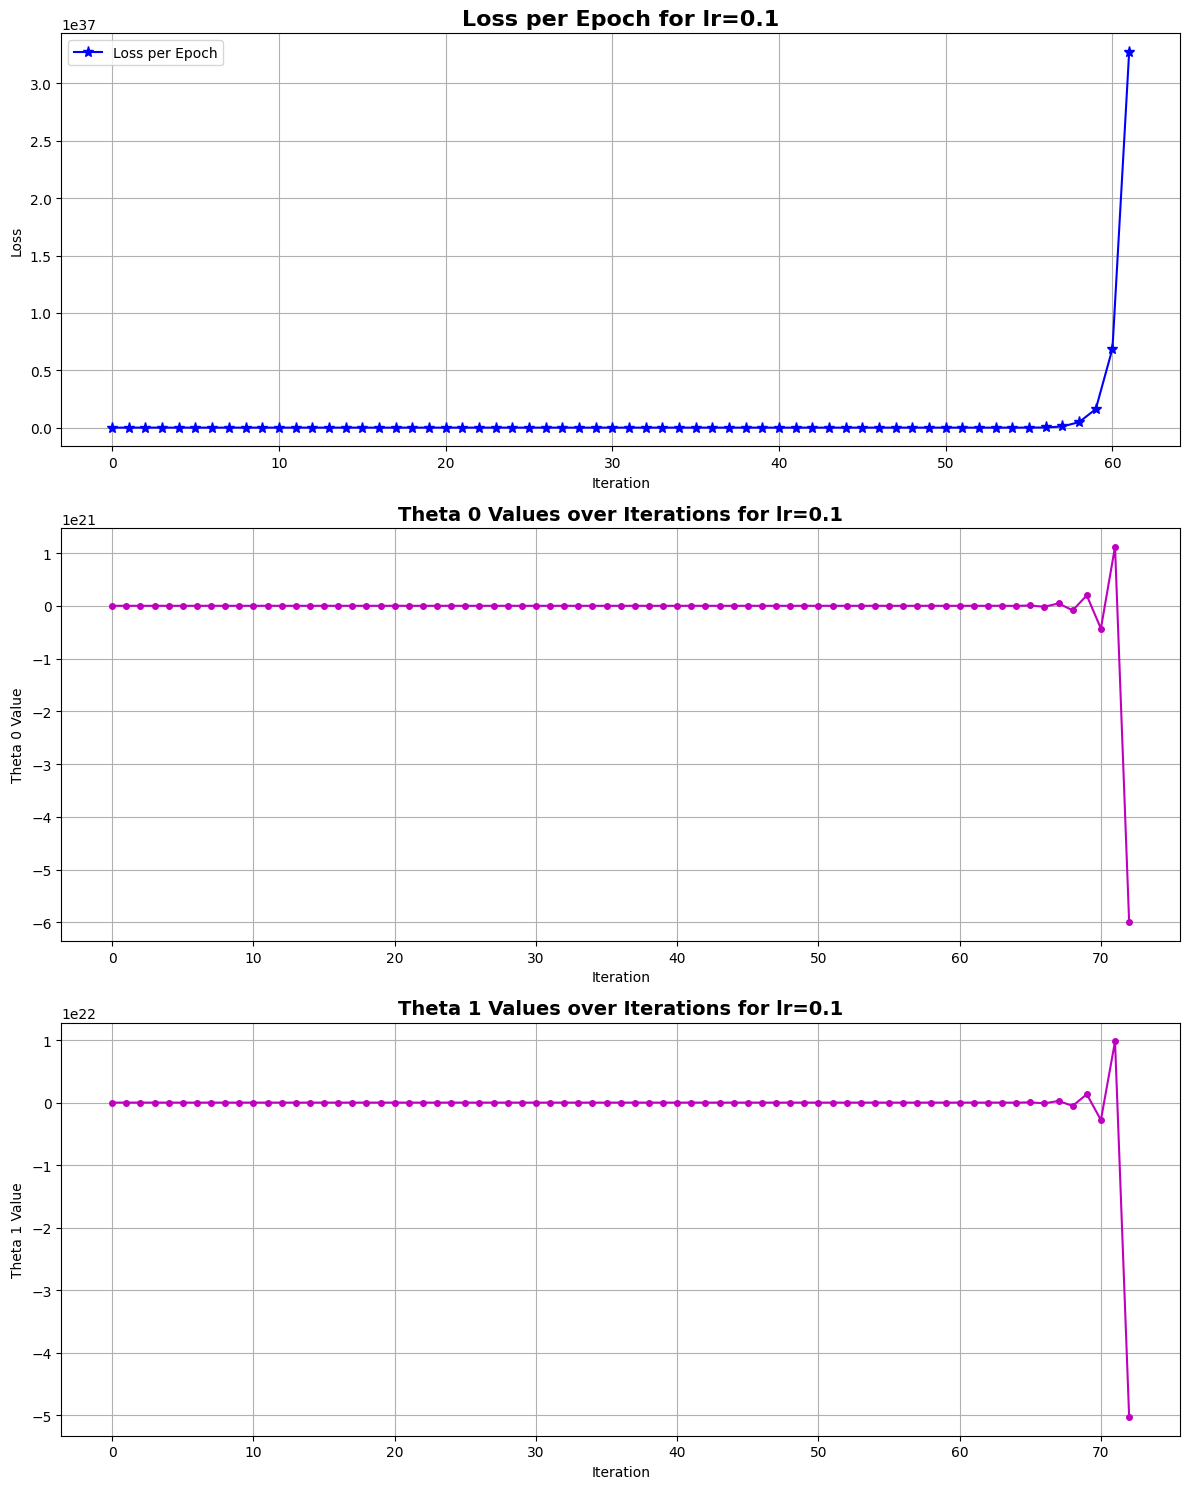

In [17]:
# Plot results
plot_results(weights_history, cost_history, lr=lr)